# Create a meshed screen with a Gaussian beam

The screen is placed at the origin in the x-y-plane.<br>
The screen normal is pointing in the negative z direction (x - right, y - up).<br>
The beam is propagating in positive z direction.

if not yet available some libraries have to be installed :<br>
- gmsh (best installed globally through package management system)
- python3 -m pip install pygmsh --user
- python3 -m pip install vtk --user

In [1]:
import numpy as np
from scipy import constants
from MeshedFields import *

In [2]:
source = MeshedField.CircularMesh(R=0.04, ratio=1.0, lcar=0.1)
print("%d points" % len(source.points))
print("%d triangles" % len(source.triangles))

464 points
858 triangles


In [3]:
area = source.MeshArea()
print(np.min(area))
print(np.max(area))
print(np.sum(area))

3.19230381755e-06
1.05029470381e-05
0.00501847758487


In [4]:
normals = source.MeshNormals()
print(np.sum(normals, axis=0))

[   0.    0. -858.]


### define the beam parameters

In [5]:
# time step
dt=1.0e-13
NOTS=400

# wave parameters
tau = 4.0e-12
f = 0.3e12
print("f = %.2f THz" % (f*1e-12))
w0 = 0.02
lam = constants.c/f
print("λ = %.2f µm" % (lam*1e6))
zR = np.pi*w0*w0/lam
print("w0 = %.2f mm" % (1e3*w0))
print("Rayleigh range = %.3f m" % zR)


f = 0.30 THz
λ = 999.31 µm
w0 = 20.00 mm
Rayleigh range = 1.258 m


### compute the field traces for every point

In [6]:
# all points use the same timing grid
t = np.linspace(-NOTS/2*dt, (NOTS/2-1)*dt, NOTS)
source.dt = dt
source.Nt = NOTS
source.t0 = np.full(source.Np,-NOTS/2*dt)
# field (6 components) traces on screen
source.A = np.zeros((source.Np,NOTS,6))
# electric field amplitude in V/m
E0 = 2.0e7
# magnetic field amplitude in T
B0 = E0 / constants.c

for ip, p in enumerate(source.pos):
    r = np.sqrt(p[0]*p[0]+p[1]*p[1])
    # field strength
    osc = np.cos(2.0*np.pi*f*t) * np.exp(-r*r/(w0*w0)) * np.exp(-np.square(t)/(2.0*tau*tau))
    Ex = E0 * osc
    Ey = np.zeros_like(Ex)
    Ez = np.zeros_like(Ex)
    Bx = np.zeros_like(Ex)
    By = B0 * osc
    Bz = np.zeros_like(Ex)
    trace = np.array([Ex,Ey,Ez,Bx,By,Bz]).transpose()
    source.A[ip] = trace

In [7]:
source.A.shape

(858, 400, 6)

In [8]:
# compute power density for plotting
area = source.MeshArea()
P = source.EnergyFlowDensity()
Pz = P[:,2]

print("total mesh area = %7.3f cm²" % (1.0e4*np.sum(area)))
print("peak energy density = %.6f J/m²" % np.max(Pz))
print("total pulse energy = %.1f µJ" % (1e6*np.dot(area,Pz)))

total mesh area =  50.185 cm²
peak energy density = 3.696647 J/m²
total pulse energy = 2364.3 µJ


### display mesh

In [9]:
source.ShowMeshedField()

In [10]:
source.ShowMeshedField(scalars=Pz,scalarTitle="Pz",showCenters=False)

In [11]:
filename="MeshGaussian.h5"
source.WriteMeshedField(filename)

In [8]:
filename="MeshGaussian.h5"
readback = MeshedField.ReadMeshedField(filename)

# compute power density for plotting
area = readback.MeshArea()
P = readback.EnergyFlowDensity()
Pz = P[:,2]

print("peak energy density = %.6f J/m²" % np.max(Pz))
print("total pulse energy = %.1f µJ" % (1e6*np.dot(area,Pz)))

readback.ShowMeshedField(scalars=Pz,scalarTitle="Pz")

peak energy density = 3.696647 J/m²
total pulse energy = 2364.3 µJ


## create target screen at 0.2 m distance

In [12]:
d = np.array([0,0,0.2])
prop_time = 0.2/constants.c
dt = source.dt
target_pts = [p + d for p in source.points]
target = MeshedField(target_pts,source.triangles)
target.t0 = [t + prop_time - 100*dt for t in source.t0]
target.Nt = source.Nt + 200
target.dt = dt

filename="NearTarget.h5"
target.WriteMeshedField(filename)

Now we propagate the beam to this target. This could be the command to run:<br>
../build/Propagate MeshGaussian.h5 NearTarget.h5 <br>
The program rewrites the file with the propagated fields. We now read and display these data.

peak energy density = 3.555892 J/m²
total pulse energy = 2451.2 µJ


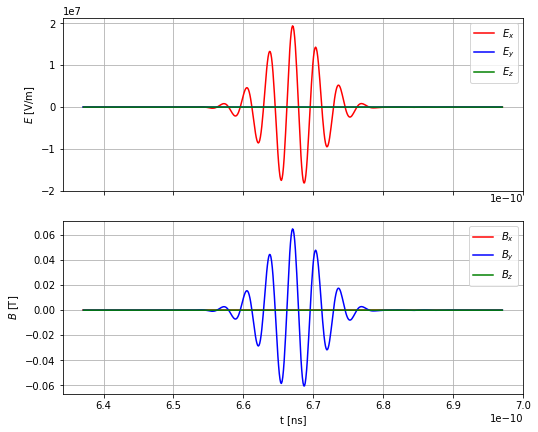

In [6]:
filename="NearTarget.h5"
readback = MeshedField.ReadMeshedField(filename)

# compute power density for plotting
area = readback.MeshArea()
P = readback.EnergyFlowDensity()
Pz = P[:,2]

print("peak energy density = %.6f J/m²" % np.max(Pz))
print("total pulse energy = %.1f µJ" % (1e6*np.dot(area,Pz)))

def pick(id):
    readback.ShowFieldTrace(id)
    
readback.ShowMeshedField(scalars=Pz,scalarTitle="Pz",pickAction=pick)

In [4]:
NOTS = readback.Nt
Ex = readback.A[:,NOTS//2,0]

readback.ShowMeshedField(scalars=Ex,scalarTitle="Ex [V/m]",lut=phaseLUT())

In [5]:
filename="NearTargetHD.h5"
readback = MeshedField.ReadMeshedField(filename)

# compute power density for plotting
area = readback.MeshArea()
P = readback.EnergyFlowDensity()
Pz = P[:,2]

print("peak energy density = %.6f J/m²" % np.max(Pz))
print("total pulse energy = %.1f µJ" % (1e6*np.dot(area,Pz)))

def pick(id):
    readback.ShowFieldTrace(id)
    
readback.ShowMeshedField(scalars=Pz,scalarTitle="Pz",pickAction=pick,highlight=[340,6591])

peak energy density = 3.594589 J/m²
total pulse energy = 2321.2 µJ


## create target screen at 1.258 m distance

In [17]:
d = np.array([0,0,1.258])
prop_time = 1.258/constants.c
target_pts = [p*1.4 + d for p in source.points]
target = MeshedField(target_pts,source.triangles)
target.t0 = [prop_time+t for t in source.t0]
target.Nt = source.Nt
target.dt = source.dt

filename="Target.h5"
target.WriteMeshedField(filename)

In [18]:
filename="Target.h5"
readback = MeshedField.ReadMeshedField(filename)

# compute power density for plotting
area = readback.MeshArea()
P = readback.EnergyFlowDensity()
Pz = P[:,2]

print("peak energy density = %.6f J/m²" % np.max(Pz))
print("total pulse energy = %.1f µJ" % (1e6*np.dot(area,Pz)))

readback.ShowMeshedField(scalars=Pz,scalarTitle="Pz")

peak energy density = 1.843196 J/m²
total pulse energy = 2320.8 µJ
